# MODELO RNN


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from statsmodels.stats.diagnostic import acorr_ljungbox
import matplotlib.pyplot as plt
import statsmodels.api as sm
from math import sqrt

## Datos

In [2]:
data = pd.read_csv(r"C:\Users\claud\Downloads\Bitcoin Historical Data.csv")
data

Date     Price      Open      High       Low     Vol. Change %
0     03/24/2024  67,211.9  64,036.5  67,587.8  63,812.9   65.59K    4.96%
1     03/23/2024  64,037.8  63,785.6  65,972.4  63,074.9   35.11K    0.40%
2     03/22/2024  63,785.5  65,501.5  66,633.3  62,328.3   72.43K   -2.62%
3     03/21/2024  65,503.8  67,860.0  68,161.7  64,616.1   75.26K   -3.46%
4     03/20/2024  67,854.0  62,046.8  68,029.5  60,850.9  133.53K    9.35%
...          ...       ...       ...       ...       ...      ...      ...
4994  07/22/2010       0.1       0.1       0.1       0.1    2.16K    0.00%
4995  07/21/2010       0.1       0.1       0.1       0.1    0.58K    0.00%
4996  07/20/2010       0.1       0.1       0.1       0.1    0.26K    0.00%
4997  07/19/2010       0.1       0.1       0.1       0.1    0.57K    0.00%
4998  07/18/2010       0.1       0.0       0.1       0.1    0.08K    0.00%

[4999 rows x 7 columns]

Para que los datos estén en el formato correcto se les aplicará el siguiente proceso de eliminación de formatos 

In [3]:
# Eliminar comas y convertir las columnas relevantes a float
data['Price'] = data['Price'].str.replace(',', '').astype(float)
data['Open'] = data['Open'].str.replace(',', '').astype(float)
data['High'] = data['High'].str.replace(',', '').astype(float)
# Función para convertir valores con 'K', 'M', 'B' o números directos
def convert_volume(value):
    # Verificar si el valor ya es numérico
    if isinstance(value, float) or isinstance(value, int):
        return value  # Devolver el valor si ya es numérico
    elif 'K' in value:
        return float(value.replace('K', '')) * 1_000
    elif 'M' in value:
        return float(value.replace('M', '')) * 1_000_000
    elif 'B' in value:
        return float(value.replace('B', '')) * 1_000_000_000
    else:
        return float(value.replace(',', ''))

# Aplicar la función a la columna 'Vol.'
data['Vol.'] = data['Vol.'].apply(convert_volume)

# Verificar que la conversión haya sido exitosa
print(data[['Vol.']].head())


       Vol.
0   65590.0
1   35110.0
2   72430.0
3   75260.0
4  133530.0


Se verifica el formato de la fecha y se agrega la columnna indice 

In [4]:
# Asegurarse de que la columna "Date" sea de tipo datetime
data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%Y')
# Ordenar los datos por fecha de forma ascendente
data = data.sort_values(by='Date', ascending=True).reset_index(drop=True)
# Verificar si hay valores nulos en cada columna
print(data.isnull().sum())
# Alternativa: Mostrar las filas que contengan valores faltantes
missing_data = data[data.isnull().any(axis=1)]
print(f"Filas con datos faltantes:\n{missing_data}")

# Asegúrate de que la columna 'Date' esté en formato datetime

# Convertir la fecha a un timestamp (número de días desde Epoch)

# Ver las primeras filas con la nueva columna numérica
data['indice'] = range(len(data))

Date        0
Price       0
Open        0
High        0
Low         0
Vol.        6
Change %    0
dtype: int64
Filas con datos faltantes:
          Date  Price  Open  High   Low  Vol. Change %
337 2011-06-20   17.5  17.5  17.5  17.5   NaN    0.00%
338 2011-06-21   17.5  17.5  17.5  17.5   NaN    0.00%
339 2011-06-22   17.5  17.5  17.5  17.5   NaN    0.00%
340 2011-06-23   17.5  17.5  17.5  17.5   NaN    0.00%
341 2011-06-24   17.5  17.5  17.5  17.5   NaN    0.00%
342 2011-06-25   17.5  17.5  17.5  17.5   NaN    0.00%


## Funcines 

### Ventanas deslizantes
Para esto creamos una función que divide los datos en entrenamiento, validación y prueba. Esta función avanca con un paso de 1. las ventanas y el horizonte de predicción son variables 

In [5]:
import numpy as np


def create_sliding_windows(data, window_size, horizon):
    

    X_train, Y_train = [], []
    X_val, Y_val = [], []
    X_test, Y_test = [], []

    # Generar ventanas deslizantes con sus índices correspondientes
    for i in range(0, len(data) - window_size - 3 * horizon + 1, 1):
        # Entrenamiento
        X_train.append(data[i:i + window_size])
        Y_train.append(data[i + window_size:i + window_size + horizon])

        # Validación
        X_val.append(data[i + window_size:i + window_size + horizon])
        Y_val.append(data[i + window_size + horizon:i + window_size + 2 * horizon])

        # Prueba
        X_test.append(data[i + window_size + horizon:i + window_size + 2 * horizon])
        Y_test.append(data[i + window_size + 2 * horizon:i + window_size + 3 * horizon])

    # Convertir las ventanas a arrays NumPy con forma (n_samples, timesteps, features)
    
    # Convertir a arrays de NumPy y ajustar las dimensiones
    X_train = np.array(X_train).reshape(-1, window_size, 1)  # (n_samples, timesteps, n_features)
    X_val = np.array(X_val).reshape(-1, window_size, 1)
    X_test = np.array(X_test).reshape(-1, window_size, 1)

    Y_train = np.array(Y_train)  # (n_samples, horizon)
    Y_val = np.array(Y_val)
    Y_test = np.array(Y_test)

    return X_train, Y_train, X_val, Y_val, X_test, Y_test


### Construcción del Modelo
Creamos una función para crear el modelo teniendo en cuenta los parametros de las iteraciones neurons, window, dropout_rate, horizon. Batch size se aplicará más adelante 

In [6]:

from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, Input

def build_rnn_model(neurons, window, dropout_rate, horizon):
    model = Sequential()
    model.add(Input(shape=(window, 1)))
    model.add(SimpleRNN(neurons, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(horizon))  
    model.compile(optimizer='adam', loss='mse')  # Usar la pérdida personalizada
    return model


In [7]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import q_stat, acf
import statsmodels.api as sm
from scipy.stats import shapiro


### Métricas
Creamos una función que calcule las metricas importantes

In [8]:

def metricas(windows, pred, neurons, batchsize, dropout_rate, horizon, window):
    
    # Calcular métricas en Validación
    if np.isnan(pred).any():
        print("Advertencia: Las predicciones contienen NaN.")
        metrics=None
    else:
        
        mae = mean_absolute_error(windows, pred)
        mse = mean_squared_error(windows, pred)
        rmse = np.sqrt(mse)
        mape = np.mean(np.abs((windows - pred) / windows)) * 100
        r2 = r2_score(windows, pred)

        
        # Guardar métricas del conjunto de validación junto con pruebas de hipótesis
        metrics = {
            'neurons': neurons,
            'batchsize': batchsize,
            'Dropout': dropout_rate,
            'horizon': horizon,
            'window': window,
            'MAPE': mape,
            'MAE': mae,
            'MSE': mse,
            'RMSE': rmse,
            'R2': r2,
        
    }
    return metrics


In [9]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import acf, q_stat
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import plotly.express as px
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler


### Función de optimización
se creo una función con la cual se itera entre todas las posibles combinaciones de paramtros. Se tiene en cuenta el early stoping y la estabilización de la metrica mse para encontar el mejor modelo. luego de que el mse no varie más del 5% 5 iteraciones seguidas se detiene. Además se guardan los residuos y metricas de cada modelo para su posterior uso.

In [10]:
def busqueda(datos, windows, horizons, dropout_rates, batchsizes, neurons_list):
    validation_metrics = []
    test_metrics = []
    train_metrics = []
    residual_hist = []

    best_model = None
    params_best_model = {}
    best_score = np.inf 
    previous_mse = None  # Para rastrear el MSE de la iteración anterior
    residuals_bestmodel = None
    stable_iterations = 0  # Contador para rastrear iteraciones estables

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )

    for neurons in neurons_list:
        for window in windows:
            for horizon in horizons:
                if window == horizon:
                    x_train, y_train, x_val, y_val, x_test, y_test = create_sliding_windows(
                        datos, window, horizon)
                    for dropout_rate in dropout_rates:
                        for batchsize in batchsizes:

                            # Crear y entrenar el modelo
                            print(f"Entrenando modelo con {neurons} neuronas, dropout {dropout_rate}, "
                                  f"batch size {batchsize}, horizon {horizon}, window {window}")
                            model = build_rnn_model(neurons, window, dropout_rate, horizon)

                            early_stop = EarlyStopping(
                                monitor='val_loss', patience=2, 
                                restore_best_weights=True, verbose=1)

                            history = model.fit(
                                x_train, y_train,
                                validation_data=(x_val, y_val),
                                callbacks=[early_stop],
                                epochs=1, batch_size=batchsize, verbose=0
                            )

                            # Predicciones y cálculo de residuos
                            val_pred = model.predict(x_val)
                            test_pred = model.predict(x_test)
                            train_pred = model.predict(x_train)

                            residuals = y_val - val_pred  # Residuos de validación
                            residual_hist.append({
                                'neurons': neurons,
                                'batchsize': batchsize,
                                'dropout_rate': dropout_rate,
                                'horizon': horizon,
                                'window': window,
                                'residuals': residuals
                            })

                            # Calcular métricas en validación
                            
                            metricas_val = metricas(y_val, val_pred, neurons, batchsize, dropout_rate, horizon, window)
                            validation_metrics.append(metricas_val)

                            # Calcular métricas en prueba
                            metricas_test = metricas(y_test, test_pred, neurons, batchsize, dropout_rate, horizon, window)
                            test_metrics.append(metricas_test)

                            # Calcular métricas en entrenamiento
                            metricas_train = metricas(y_train, train_pred, neurons, batchsize, dropout_rate, horizon, window)
                            train_metrics.append(metricas_train)

                            if metricas_val:
                                mse = metricas_val['MSE']
                                print(f"MSE: {mse}")

                                # Verificar la fluctuación del MSE
                                if previous_mse:
                                    variation = abs(mse - previous_mse) / previous_mse
                                    if variation < 0.05:
                                        stable_iterations += 1
                                        print(f"Fluctuación menor al 5% en el MSE por {stable_iterations} iteración(es).")
                                    else:
                                        stable_iterations = 0  # Reiniciar contador si hay variación mayor al 5%

                                    if stable_iterations >= 5:
                                        print("Fluctuación menor al 5% durante 5 iteraciones consecutivas. Deteniendo la búsqueda.")
                                        return (validation_metrics, test_metrics, train_metrics, 
                                                residual_hist, best_model, params_best_model, residuals_bestmodel)

                                previous_mse = mse

                                # Guardar el mejor modelo si es necesario
                                if mse < best_score:
                                    best_score = mse
                                    best_model = model
                                    params_best_model = {
                                        'neurons': neurons,
                                        'batchsize': batchsize,
                                        'dropout_rate': dropout_rate,
                                        'horizon': horizon,
                                        'window': window,
                                        'MSE': mse
                                    }
                                    residuals_bestmodel = residuals

    return (validation_metrics, test_metrics, train_metrics, residual_hist, best_model, params_best_model, residuals_bestmodel)


## Serie Price
Utilización de las funciones para encontrar los mejores parametros para la serie de tiempo `Price`


In [11]:
windows=[7,14,21,28]
horizons=[7,14,21,28]
dropout_rates=[0.2,0.4,0.6,0.8]
batchsizes=[16,32,64,128]
neurons_list=[10]


datos=data['Price']
validation_metrics_price,test_metrics_price,train_metrics_price,residual_hist_price,best_model_price,params_best_model_price,residuals_bestmodel_price=busqueda (datos,windows,horizons,dropout_rates,batchsizes,neurons_list)

Entrenando modelo con 10 neuronas, dropout 0.2, batch size 16, horizon 7, window 7


  1/156 [..............................] - ETA: 19s

 36/156 [=====>........................] - ETA: 0s 

 78/156 [==============>...............] - ETA: 0s

126/156 [=======================>......] - ETA: 0s

156/156 [==============================] - 0s 1ms/step


  1/156 [..............................] - ETA: 2s

 41/156 [======>.......................] - ETA: 0s

 89/156 [================>.............] - ETA: 0s

133/156 [========================>.....] - ETA: 0s

156/156 [==============================] - 0s 1ms/step


  1/156 [..............................] - ETA: 1s

 38/156 [======>.......................] - ETA: 0s

 88/156 [===============>..............] - ETA: 0s

140/156 [=========================>....] - ETA: 0s

156/156 [==============================] - 0s 1ms/step


MSE: 47416061.018751904
Entrenando modelo con 10 neuronas, dropout 0.2, batch size 32, horizon 7, window 7


  1/156 [..............................] - ETA: 12s

 42/156 [=======>......................] - ETA: 0s 

 96/156 [=================>............] - ETA: 0s

151/156 [============================>.] - ETA: 0s

156/156 [==============================] - 0s 1ms/step


  1/156 [..............................] - ETA: 2s

 44/156 [=======>......................] - ETA: 0s

 83/156 [==============>...............] - ETA: 0s

128/156 [=======================>......] - ETA: 0s

156/156 [==============================] - 0s 1ms/step


  1/156 [..............................] - ETA: 2s

 43/156 [=======>......................] - ETA: 0s

 91/156 [================>.............] - ETA: 0s

139/156 [=========================>....] - ETA: 0s

156/156 [==============================] - 0s 1ms/step


MSE: 19050010.529182255
Entrenando modelo con 10 neuronas, dropout 0.2, batch size 64, horizon 7, window 7


  1/156 [..............................] - ETA: 17s

 29/156 [====>.........................] - ETA: 0s 

 68/156 [============>.................] - ETA: 0s

114/156 [====================>.........] - ETA: 0s

156/156 [==============================] - 0s 1ms/step


  1/156 [..............................] - ETA: 2s

 45/156 [=======>......................] - ETA: 0s

 96/156 [=================>............] - ETA: 0s

148/156 [===========================>..] - ETA: 0s

156/156 [==============================] - 0s 1ms/step


  1/156 [..............................] - ETA: 4s

 37/156 [======>.......................] - ETA: 0s

 81/156 [==============>...............] - ETA: 0s

125/156 [=======================>......] - ETA: 0s

156/156 [==============================] - 0s 1ms/step


MSE: 210793784.49488953
Entrenando modelo con 10 neuronas, dropout 0.2, batch size 128, horizon 7, window 7


  1/156 [..............................] - ETA: 14s

 49/156 [========>.....................] - ETA: 0s 

 95/156 [=================>............] - ETA: 0s

140/156 [=========================>....] - ETA: 0s

156/156 [==============================] - 0s 1ms/step


  1/156 [..............................] - ETA: 2s

 36/156 [=====>........................] - ETA: 0s

 84/156 [===============>..............] - ETA: 0s

126/156 [=======================>......] - ETA: 0s

156/156 [==============================] - 0s 1ms/step


  1/156 [..............................] - ETA: 2s

 36/156 [=====>........................] - ETA: 0s

 79/156 [==============>...............] - ETA: 0s

129/156 [=======================>......] - ETA: 0s

156/156 [==============================] - 0s 1ms/step


MSE: 352223150.8404395


Entrenando modelo con 10 neuronas, dropout 0.4, batch size 16, horizon 7, window 7


  1/156 [..............................] - ETA: 14s

 42/156 [=======>......................] - ETA: 0s 

 86/156 [===============>..............] - ETA: 0s

117/156 [=====================>........] - ETA: 0s

144/156 [==========================>...] - ETA: 0s

156/156 [==============================] - 0s 2ms/step


  1/156 [..............................] - ETA: 2s

 37/156 [======>.......................] - ETA: 0s

 79/156 [==============>...............] - ETA: 0s

124/156 [======================>.......] - ETA: 0s

156/156 [==============================] - 0s 1ms/step


  1/156 [..............................] - ETA: 4s

 35/156 [=====>........................] - ETA: 0s

 76/156 [=============>................] - ETA: 0s

120/156 [======================>.......] - ETA: 0s

156/156 [==============================] - 0s 1ms/step


MSE: 37013691.62830005
Entrenando modelo con 10 neuronas, dropout 0.4, batch size 32, horizon 7, window 7


  1/156 [..............................] - ETA: 14s

 42/156 [=======>......................] - ETA: 0s 

 85/156 [===============>..............] - ETA: 0s

128/156 [=======================>......] - ETA: 0s

156/156 [==============================] - 0s 1ms/step


  1/156 [..............................] - ETA: 1s

 39/156 [======>.......................] - ETA: 0s

 81/156 [==============>...............] - ETA: 0s

124/156 [======================>.......] - ETA: 0s

156/156 [==============================] - ETA: 0s

156/156 [==============================] - 0s 2ms/step


  1/156 [..............................] - ETA: 2s

 38/156 [======>.......................] - ETA: 0s

 82/156 [==============>...............] - ETA: 0s

130/156 [========================>.....] - ETA: 0s

156/156 [==============================] - 0s 1ms/step


MSE: 82728705.36450133
Entrenando modelo con 10 neuronas, dropout 0.4, batch size 64, horizon 7, window 7


  1/156 [..............................] - ETA: 14s

 40/156 [======>.......................] - ETA: 0s 

 88/156 [===============>..............] - ETA: 0s

135/156 [========================>.....] - ETA: 0s

156/156 [==============================] - 0s 1ms/step


  1/156 [..............................] - ETA: 2s

 37/156 [======>.......................] - ETA: 0s

 85/156 [===============>..............] - ETA: 0s

130/156 [========================>.....] - ETA: 0s

156/156 [==============================] - 0s 1ms/step


  1/156 [..............................] - ETA: 2s

 44/156 [=======>......................] - ETA: 0s

 91/156 [================>.............] - ETA: 0s

136/156 [=========================>....] - ETA: 0s

156/156 [==============================] - 0s 1ms/step


MSE: 173991118.74782473


Entrenando modelo con 10 neuronas, dropout 0.4, batch size 128, horizon 7, window 7


  1/156 [..............................] - ETA: 14s

 45/156 [=======>......................] - ETA: 0s 

 98/156 [=================>............] - ETA: 0s

150/156 [===========================>..] - ETA: 0s

156/156 [==============================] - 0s 1ms/step


  1/156 [..............................] - ETA: 2s

 38/156 [======>.......................] - ETA: 0s

 82/156 [==============>...............] - ETA: 0s

126/156 [=======================>......] - ETA: 0s

156/156 [==============================] - 0s 1ms/step


  1/156 [..............................] - ETA: 2s

 32/156 [=====>........................] - ETA: 0s

 78/156 [==============>...............] - ETA: 0s

123/156 [======================>.......] - ETA: 0s

156/156 [==============================] - 0s 1ms/step


MSE: 378258323.70265234
Entrenando modelo con 10 neuronas, dropout 0.6, batch size 16, horizon 7, window 7


  1/156 [..............................] - ETA: 18s

 39/156 [======>.......................] - ETA: 0s 

 89/156 [================>.............] - ETA: 0s

134/156 [========================>.....] - ETA: 0s

156/156 [==============================] - 0s 1ms/step


  1/156 [..............................] - ETA: 2s

 45/156 [=======>......................] - ETA: 0s

 94/156 [=================>............] - ETA: 0s

138/156 [=========================>....] - ETA: 0s

156/156 [==============================] - 0s 1ms/step


  1/156 [..............................] - ETA: 2s

 34/156 [=====>........................] - ETA: 0s

 81/156 [==============>...............] - ETA: 0s

125/156 [=======================>......] - ETA: 0s

156/156 [==============================] - 0s 1ms/step


MSE: 111584404.72602606
Entrenando modelo con 10 neuronas, dropout 0.6, batch size 32, horizon 7, window 7


  1/156 [..............................] - ETA: 14s

 37/156 [======>.......................] - ETA: 0s 

 78/156 [==============>...............] - ETA: 0s

117/156 [=====================>........] - ETA: 0s

156/156 [==============================] - 0s 1ms/step


  1/156 [..............................] - ETA: 1s

 49/156 [========>.....................] - ETA: 0s

102/156 [==================>...........] - ETA: 0s

155/156 [============================>.] - ETA: 0s

156/156 [==============================] - 0s 1ms/step


  1/156 [..............................] - ETA: 2s

 44/156 [=======>......................] - ETA: 0s

 97/156 [=================>............] - ETA: 0s

143/156 [==========================>...] - ETA: 0s

156/156 [==============================] - 0s 1ms/step


MSE: 275167246.779151
Entrenando modelo con 10 neuronas, dropout 0.6, batch size 64, horizon 7, window 7


  1/156 [..............................] - ETA: 14s

 32/156 [=====>........................] - ETA: 0s 

 77/156 [=============>................] - ETA: 0s

122/156 [======================>.......] - ETA: 0s

156/156 [==============================] - 0s 1ms/step


  1/156 [..............................] - ETA: 2s

 39/156 [======>.......................] - ETA: 0s

 84/156 [===============>..............] - ETA: 0s

127/156 [=======================>......] - ETA: 0s

156/156 [==============================] - 0s 2ms/step


  1/156 [..............................] - ETA: 2s

 35/156 [=====>........................] - ETA: 0s

 70/156 [============>.................] - ETA: 0s

111/156 [====================>.........] - ETA: 0s

156/156 [==============================] - ETA: 0s

156/156 [==============================] - 0s 1ms/step


MSE: 233532732.70322943
Entrenando modelo con 10 neuronas, dropout 0.6, batch size 128, horizon 7, window 7


  1/156 [..............................] - ETA: 14s

 42/156 [=======>......................] - ETA: 0s 

 84/156 [===============>..............] - ETA: 0s

129/156 [=======================>......] - ETA: 0s

156/156 [==============================] - 0s 1ms/step


  1/156 [..............................] - ETA: 2s

 37/156 [======>.......................] - ETA: 0s

 80/156 [==============>...............] - ETA: 0s

123/156 [======================>.......] - ETA: 0s

156/156 [==============================] - 0s 2ms/step


  1/156 [..............................] - ETA: 2s

 38/156 [======>.......................] - ETA: 0s

 83/156 [==============>...............] - ETA: 0s

123/156 [======================>.......] - ETA: 0s

156/156 [==============================] - 0s 2ms/step


MSE: 261558691.69503015
Entrenando modelo con 10 neuronas, dropout 0.8, batch size 16, horizon 7, window 7


  1/156 [..............................] - ETA: 17s

 38/156 [======>.......................] - ETA: 0s 

 78/156 [==============>...............] - ETA: 0s

110/156 [====================>.........] - ETA: 0s

152/156 [============================>.] - ETA: 0s

156/156 [==============================] - 0s 2ms/step


  1/156 [..............................] - ETA: 4s

 30/156 [====>.........................] - ETA: 0s

 69/156 [============>.................] - ETA: 0s

100/156 [==================>...........] - ETA: 0s

133/156 [========================>.....] - ETA: 0s

156/156 [==============================] - 0s 2ms/step


  1/156 [..............................] - ETA: 2s

 49/156 [========>.....................] - ETA: 0s

KeyboardInterrupt: 

Para evitar el desgaste hemos dividido las iteraciones
Según la optimización los mejores parametros son:

In [225]:
params_best_model_price

{'neurons': 10,
 'batchsize': 16,
 'dropout_rate': 0.2,
 'horizon': 7,
 'window': 7,
 'MSE': 6246252.279987531}

Guardaremos los datos relevantes de estas iteraciones, y luego haremos iteraciones con 1000 neuronas

In [226]:
def guardar_resultados(
    validation_metrics_price, test_metrics_price, train_metrics_price, 
    residual_hist_price, best_model_price, params_best_model_price, 
    residuals_bestmodel_price,
    resultados
):
   
    # Hacer append de cada métrica en la lista correspondiente dentro del diccionario
    resultados['validation_metrics_price'].append(validation_metrics_price)
    resultados['test_metrics_price'].append(test_metrics_price)
    resultados['train_metrics_price'].append(train_metrics_price)
    resultados['residual_hist_price'].append(residual_hist_price)
    resultados['best_model_price'].append(best_model_price)
    resultados['params_best_model_price'].append(params_best_model_price)
    resultados['residuals_bestmodel_price'].append(residuals_bestmodel_price)


In [228]:
resultados = {
    'validation_metrics_price': [],
    'test_metrics_price': [],
    'train_metrics_price': [],
    'residual_hist_price': [],
    'best_model_price': [],
    'params_best_model_price': [],
    'residuals_bestmodel_price': []
}
guardar_resultados(validation_metrics_price,test_metrics_price,train_metrics_price,residual_hist_price,best_model_price,params_best_model_price,residuals_bestmodel_price,resultados)

In [229]:
windows=[7,14,21,28]
horizons=[7,14,21,28]
dropout_rates=[0.2,0.4,0.6,0.8]
batchsizes=[16,32,64,128]
neurons_list=[1000]


datos=data['Price']
validation_metrics_price,test_metrics_price,train_metrics_price,residual_hist_price,best_model_price,params_best_model_price,residuals_bestmodel_price=busqueda (datos,windows,horizons,dropout_rates,batchsizes,neurons_list)

Entrenando modelo con 1000 neuronas, dropout 0.2, batch size 16, horizon 7, window 7
156/156 [==============================] - 2s 15ms/step
MSE: 5635618.415696868
Entrenando modelo con 1000 neuronas, dropout 0.2, batch size 32, horizon 7, window 7
156/156 [==============================] - 2s 16ms/step
MSE: 3640202.588340754
Entrenando modelo con 1000 neuronas, dropout 0.2, batch size 64, horizon 7, window 7
156/156 [==============================] - 3s 17ms/step
MSE: 2779506.0117820096
Entrenando modelo con 1000 neuronas, dropout 0.2, batch size 128, horizon 7, window 7
156/156 [==============================] - 3s 17ms/step
MSE: 2878977.635523868
Fluctuación menor al 5% en el MSE por 1 iteración(es).
Entrenando modelo con 1000 neuronas, dropout 0.4, batch size 16, horizon 7, window 7
156/156 [==============================] - 3s 17ms/step
MSE: 4561515.654465702
Entrenando modelo con 1000 neuronas, dropout 0.4, batch size 32, horizon 7, window 7
156/156 [=============================

In [232]:
print(params_best_model_price)
guardar_resultados(validation_metrics_price,test_metrics_price,train_metrics_price,residual_hist_price,best_model_price,params_best_model_price,residuals_bestmodel_price,resultados)

{'neurons': 1000, 'batchsize': 16, 'dropout_rate': 0.6, 'horizon': 7, 'window': 7, 'MSE': 2604637.0266452082}


De esta iteración podemos ver que a mayor neuronas se logró un mejor resultado del mse. Además coincide el tamaño de las ventanas y el batch size. por lo que para la siguientes iteraciones utilizaremos los siguientes parametros: 

In [233]:
windows=[7]
horizons=[7]
dropout_rates=[0.2,0.6]
batchsizes=[16]
neurons_list=[10000]


datos=data['Price']
validation_metrics_price,test_metrics_price,train_metrics_price,residual_hist_price,best_model_price,params_best_model_price,residuals_bestmodel_price=busqueda (datos,windows,horizons,dropout_rates,batchsizes,neurons_list)

Entrenando modelo con 10000 neuronas, dropout 0.2, batch size 16, horizon 7, window 7
156/156 [==============================] - 125s 799ms/step
MSE: 5703626.514858782
Entrenando modelo con 10000 neuronas, dropout 0.6, batch size 16, horizon 7, window 7
156/156 [==============================] - 126s 806ms/step
MSE: 6302349.674454486


In [234]:
print(params_best_model_price)
guardar_resultados(validation_metrics_price,test_metrics_price,train_metrics_price,residual_hist_price,best_model_price,params_best_model_price,residuals_bestmodel_price,resultados)

{'neurons': 10000, 'batchsize': 16, 'dropout_rate': 0.2, 'horizon': 7, 'window': 7, 'MSE': 5703626.514858782}


In [239]:
resultados['params_best_model_price']

[{'neurons': 10,
  'batchsize': 16,
  'dropout_rate': 0.2,
  'horizon': 7,
  'window': 7,
  'MSE': 6246252.279987531},
 {'neurons': 1000,
  'batchsize': 16,
  'dropout_rate': 0.6,
  'horizon': 7,
  'window': 7,
  'MSE': 2604637.0266452082},
 {'neurons': 1000,
  'batchsize': 16,
  'dropout_rate': 0.6,
  'horizon': 7,
  'window': 7,
  'MSE': 2604637.0266452082},
 {'neurons': 10000,
  'batchsize': 16,
  'dropout_rate': 0.2,
  'horizon': 7,
  'window': 7,
  'MSE': 5703626.514858782}]

De las iteraciones podemos determinar que el mejor modelo es 
neurons': 1000,
  'batchsize': 16,
  'dropout_rate': 0.6,
  'horizon': 7,
  'window': 7,
  con
  'MSE': 2604637.0266452082


In [260]:
import pandas as pd
import numpy as np
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import acf
import matplotlib.pyplot as plt
import seaborn as sns


## Residuales
tomamos los residuos del mejor modelo para su evaluación y analisamos los residuales de cada ventana, además se mostraran las graficas para 5 ventanas aleatorias

In [283]:
res=resultados['residuals_bestmodel_price'][1]

   Ventana  LJung-Box (p-value)
0        1             0.558364
1        2             0.558364
2        3             0.558364
3        4             0.558364
4        5             0.558364
5        6             0.558364
6        7             0.558364
7        8             0.558364
8        9             0.558364
9       10             0.558364


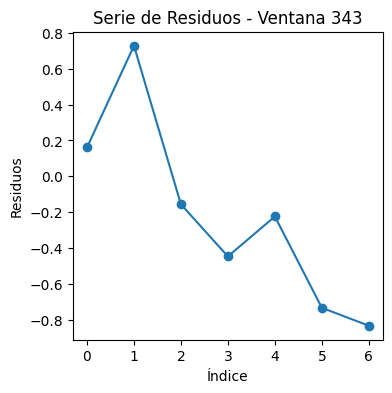

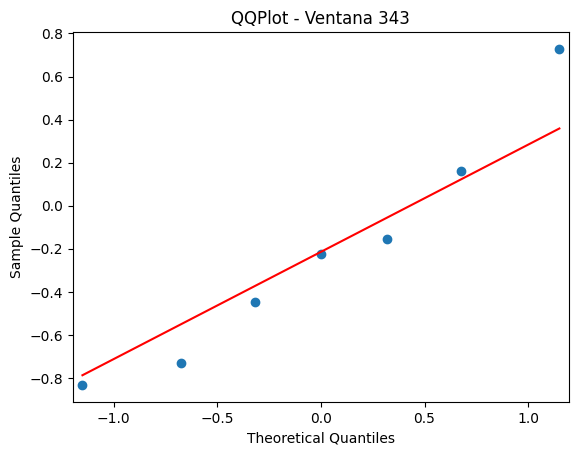

C:\Users\claud\AppData\Local\Temp\ipykernel_12348\1560686776.py:34: MatplotlibDeprecationWarning:

The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.



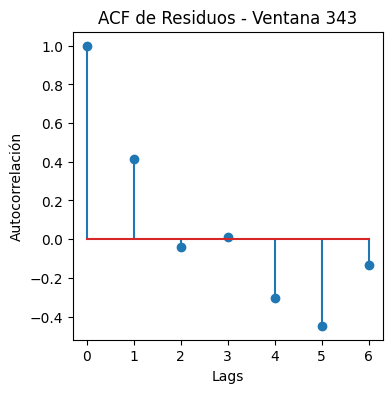

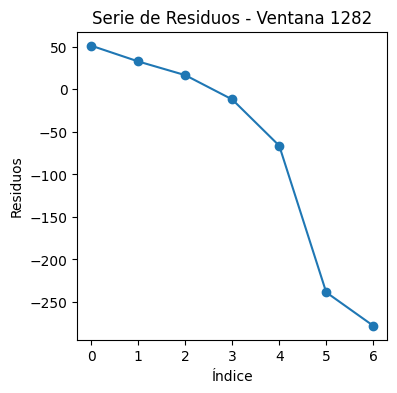

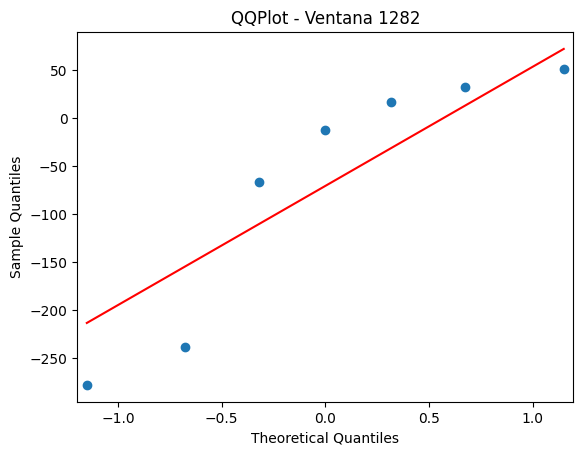

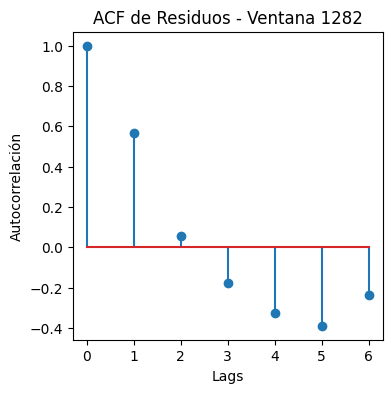

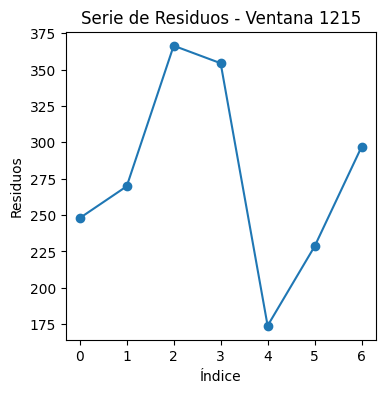

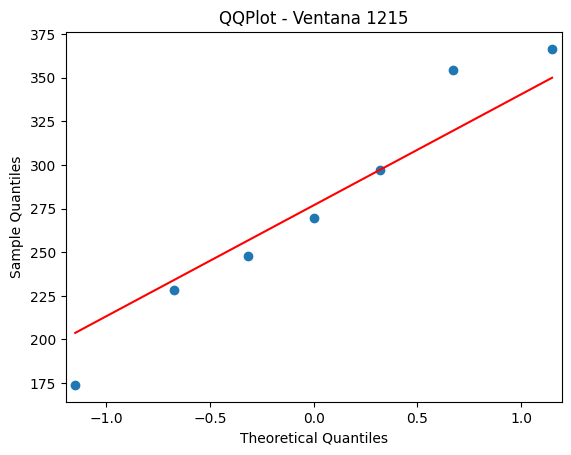

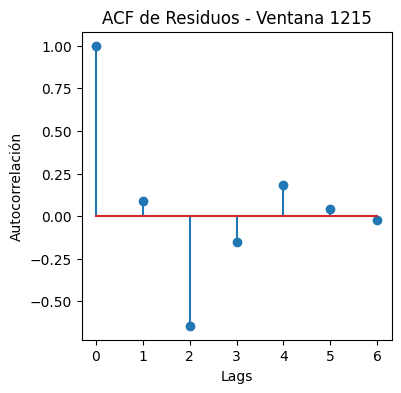

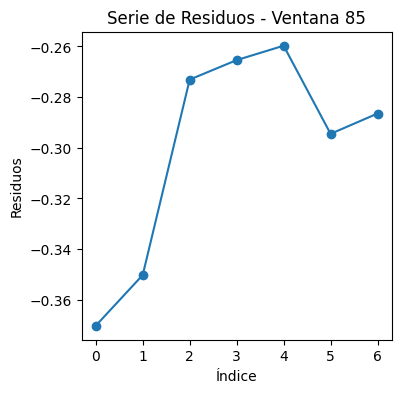

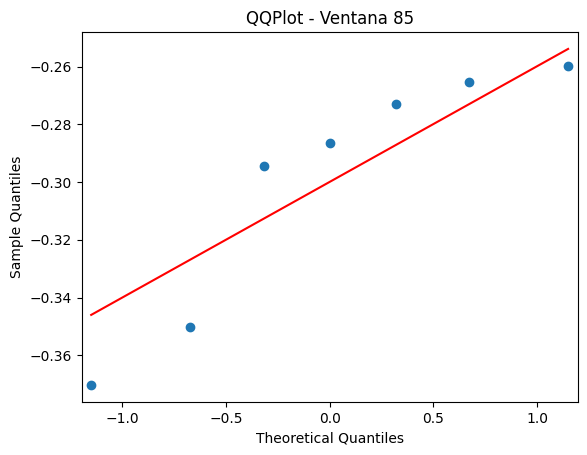

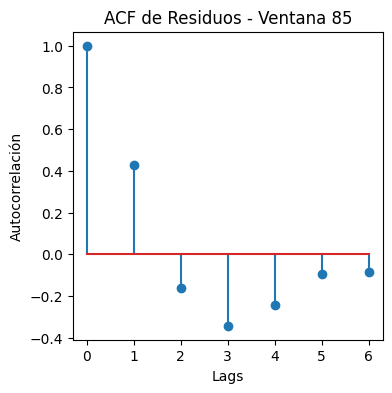

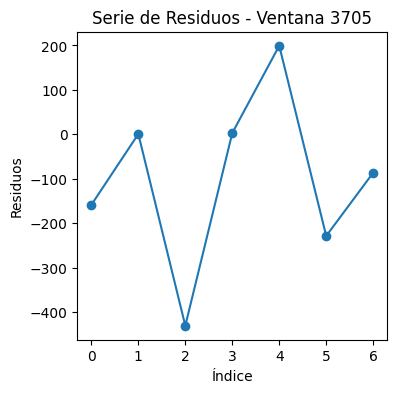

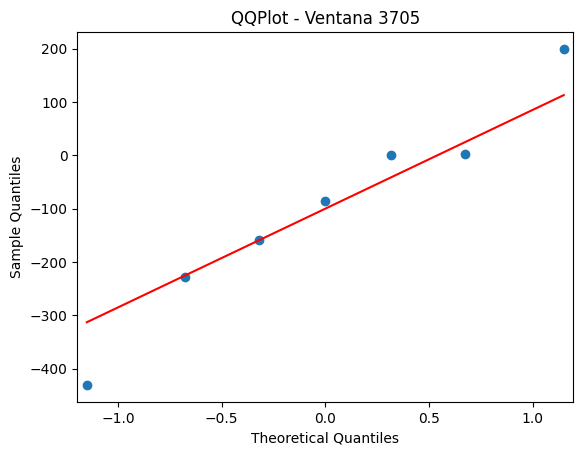

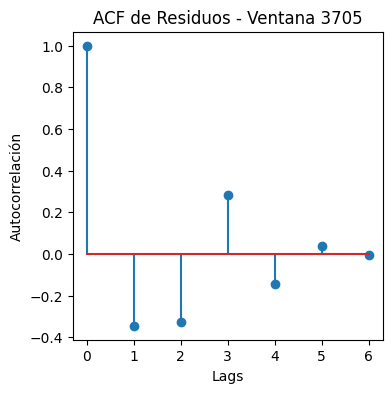

In [284]:


ljung_box_pvalues = []

for i, ventana in enumerate(res):
    ventana = np.array(ventana)
    ljung_box_pvalue = acorr_ljungbox(ventana, lags=[6], return_df=True)['lb_pvalue'].values[0]
    ljung_box_pvalues.append(ljung_box_pvalue)
df_resultados = pd.DataFrame({
    'Ventana': range(1, len(res) + 1),
    'LJung-Box (p-value)': ljung_box_pvalues
})

print(df_resultados.head(10))
# Seleccionar una muestra aleatoria de 5 ventanas para graficar
muestras = np.random.choice(len(res), size=5, replace=False)

for idx in muestras:
    ventana = np.array(res[idx])
    
    plt.figure(figsize=(4, 4))
    plt.plot(ventana, marker='o')
    plt.title(f'Serie de Residuos - Ventana {idx + 1}')
    plt.xlabel('Índice')
    plt.ylabel('Residuos')
    plt.show()

    
    qqplot(ventana, line='s')
    plt.title(f'QQPlot - Ventana {idx + 1}')
    plt.show()

    
    acf_vals = acf(ventana, nlags=min(10, len(ventana) - 1))
    plt.figure(figsize=(4, 4))
    plt.stem(range(len(acf_vals)), acf_vals, use_line_collection=True)
    plt.title(f'ACF de Residuos - Ventana {idx + 1}')
    plt.xlabel('Lags')
    plt.ylabel('Autocorrelación')
    plt.show()




De los residuales podemos secir que no cumplen cumplen, no distribuyen normal, tienen asimetria, además no son independientes.

In [292]:
metrics_list = resultados['validation_metrics_price']  # Lista que contiene los diccionarios
metricas = []

for i in metrics_list:
    for j in i: 
        
        metricas.append(j)

In [293]:
metricasval=pd.DataFrame(metricas)
metricasval = metricasval.drop_duplicates()
metricasval

neurons  batchsize  Dropout  horizon  window       MAPE          MAE  \
0         10         16      0.2        7       7  18.656426  1192.405419   
1         10         32      0.2        7       7  27.314612  2472.740715   
2         10         64      0.2        7       7  71.423901  7808.077846   
3         10        128      0.2        7       7  77.933866  8510.015369   
4         10         16      0.4        7       7  29.797139  2916.902959   
..       ...        ...      ...      ...     ...        ...          ...   
125     1000         32      0.8       28      28  16.069145  1175.212911   
126     1000         64      0.8       28      28  20.844901  1835.421206   
127     1000        128      0.8       28      28  23.708829  2034.309072   
192    10000         16      0.2        7       7  13.236866  1076.342128   
193    10000         16      0.6        7       7  14.739383  1139.591258   

              MSE          RMSE        R2  
0    6.246252e+06   2499.250344  0.974773  
1    2.621720e+07   5120.273067  0.893640  
2    2.251976e+08  15006.586747  0.090227  
3    2.518416e+08  15869.516475 -0.019343  
4    3.517161e+07   5930.565794  0.857795  
..            ...           ...       ...  
125  7.481899e+06   2735.306062  0.968281  
126  1.434736e+07   3787.790539  0.939066  
127  1.901860e+07   4361.032210  0.919068  
192  5.703627e+06   2388.226646  0.976947  
193  6.302350e+06   2510.448102  0.974530  

[130 rows x 10 columns]

In [295]:
fig = px.line(metricasval, y='MSE', title='MSE vs Índice', labels={'index': 'Índice', 'MSE': 'MSE'})

fig.show()

En esta figura podemos observar el MSE a lo largo de las iteraciones, vemos que a medida que se aumnetaron las neuronas el resultado mejoraba. Además delemitar la busqueda a partir de los parametros que ya se sabía que tenian buen desempeño permitió estabilizar la metrica.

Ahora compararemos los errores en el entrenamiento, prueba y test con la metrica mape porque esta representa los errores de manera porcentual

In [300]:
metrics_list = resultados['train_metrics_price']  # Lista que contiene los diccionarios
metricas_train = []

for i in metrics_list:
    for j in i: 
        
        metricas_train.append(j)
metricas_train=pd.DataFrame(metricas_train)
metricas_train = metricas_train.drop_duplicates()




In [302]:

metrics_list = resultados['test_metrics_price']

metricas_test = []

for i in metrics_list:
    for j in i: 
        
        metricas_test.append(j)
metricas_test=pd.DataFrame(metricas_test)
metricas_test = metricas_test.drop_duplicates()


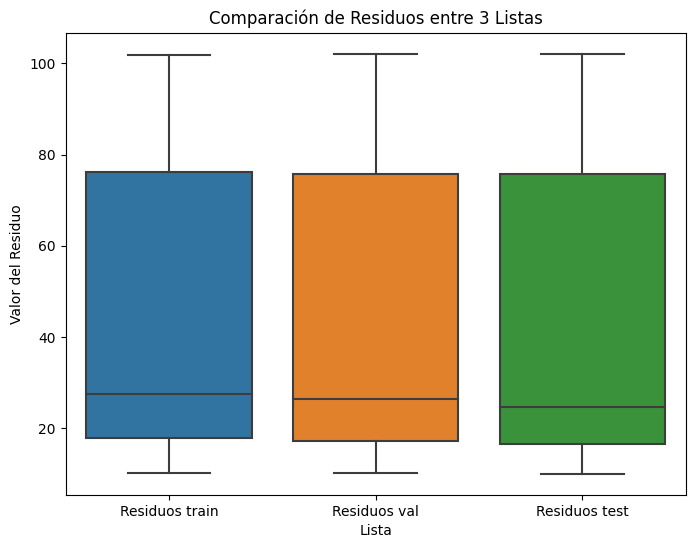

In [303]:
errores_train =  metricas_train['MAPE']
errores_val=   metricasval['MAPE']
errores_test =  metricas_test['MAPE']

# Crear una lista que contenga todas las listas de residuos
residuos = [errores_train, errores_val, errores_test]

# Crear el Boxplot usando Seaborn
plt.figure(figsize=(8, 6))
sns.boxplot(data=residuos)

# Personalizar el gráfico
plt.title('Comparación de Residuos entre 3 Listas')
plt.xlabel('Lista')
plt.ylabel('Valor del Residuo')
plt.xticks(ticks=[0, 1, 2], labels=['Residuos train', 'Residuos val', 'Residuos test'])

# Mostrar el gráfico
plt.show()

Las medianas son similares al igual que los las cajas porque al manejar la metodología de ventanas deslizantes los conjuntos son iguales a excepción de la primera y ultima ventana. sin embargo las medianas se van reduciendo porque el modelo aprende luego de evaluar el conjunto de validación  

## Prediciones

In [309]:
mejormodelo=resultados['best_model_price'][1]

X_train, Y_train, X_val, Y_val, X_test, Y_test=create_sliding_windows(datos, 7, 7)

train=mejormodelo.predict(X_train)
val=mejormodelo.predict(X_val)
test=mejormodelo.predict(X_test)

156/156 [==============================] - 3s 21ms/step


In [318]:
import plotly.express as px
import pandas as pd

df = pd.DataFrame(train)

datos = []
for i, row in enumerate(df.values):
    for j, value in enumerate(row):
        datos.append({"Fila": f"Fila {i + 1}", "Índice": i + 1 + j, "Valor": value})

df_plot = pd.DataFrame(datos)

fig = px.line(
    df_plot, 
    x="Índice", 
    y="Valor", 
    color="Fila", 
    markers=True, 
    title="Gráfico de Filas del Array con Ventanas Superpuestas"
)

fig.show()


Aquí podemos ver la predicción de las ventanas para entrenamiento de manera independiente

In [330]:

train_data = []
for i, row in enumerate(train):
    for j, value in enumerate(row):
        train_data.append({
            "Conjunto": "Train", 
            "Índice": i + 1 + j, 
            "Valor": value
        })
        
val_data = []
for i, row in enumerate(val):
    for j, value in enumerate(row):
        train_data.append({
            "Conjunto": "val",  
            "Índice": i + 8+ j, 
            "Valor": value
        })
test_data = []
for i, row in enumerate(test):
    for j, value in enumerate(row):
        train_data.append({
            "Conjunto": "test",  
            "Índice": i + 16+ j, 
            "Valor": value
        })

# Preparar los datos para la lista 'datos'
datos_data = []
for i, value in enumerate(data['Price']):
    datos_data.append({
        "Conjunto": "Datos", 
        "Fila": "Serie Datos", 
        "Índice": i+1,  
        "Valor": value
    })

# Combinar ambos conjuntos de datos en un DataFrame
df_plot = pd.DataFrame(train_data + datos_data+val_data+test_data)

# Crear el gráfico con Plotly Express
fig = px.line(
    df_plot, 
    x="Índice", 
    y="Valor", 
    color="Conjunto",  # Diferenciar 'Train' y 'Datos'
      # Mantener la separación por filas
    markers=True, 
    title="Gráfico de Train y Lista Datos"
)

# Mostrar la figura
fig.show()

En la grafica se puede los horizones de predicción para cada ventana. el conjunto de train es igual al de validación sin embargo la prueba se mantiene con diferencia